Company XYZ sells a software for 39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price (39), while a random sample of 33 users a higher price (59).
The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

## Question 1: Should the company sell its software for 39 or 59?

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
import scipy.stats as st
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier


In [4]:
test_result.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [6]:
user_table.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [8]:
df= test_result.merge(user_table, how = 'left', on = 'user_id')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316800 entries, 0 to 316799
Data columns (total 12 columns):
user_id             316800 non-null int64
timestamp           316800 non-null object
source              316800 non-null object
device              316800 non-null object
operative_system    316800 non-null object
test                316800 non-null int64
price               316800 non-null int64
converted           316800 non-null int64
city                275616 non-null object
country             275616 non-null object
lat                 275616 non-null float64
long                275616 non-null float64
dtypes: float64(2), int64(4), object(6)
memory usage: 31.4+ MB


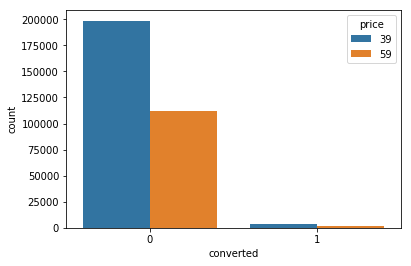

In [12]:
sns.countplot(x = 'converted', hue= 'price', data= df)

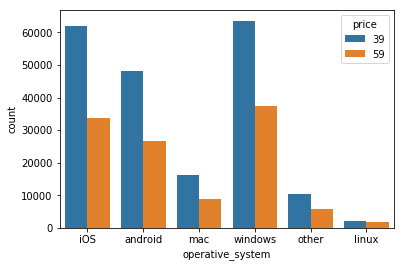

In [13]:
sns.countplot(x = 'operative_system', hue= 'price', data= df)

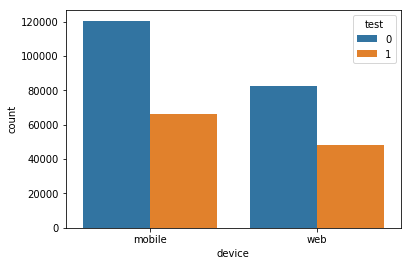

In [15]:
sns.countplot(x = 'device', hue= 'test', data= df)

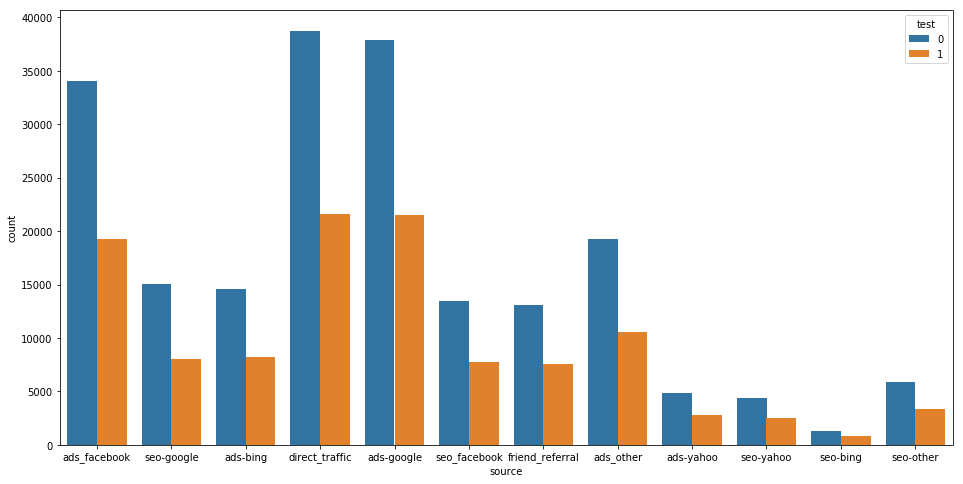

In [18]:
fig, ax = plt.subplots(figsize= (16,8))
sns.countplot(x = 'source', hue= 'test', data= df)

In [27]:
# check user geography

In [19]:
df['country'].value_counts()

USA    275616
Name: country, dtype: int64

In [24]:
city = pd.value_counts(df['city'].values, sort = True)[:10]

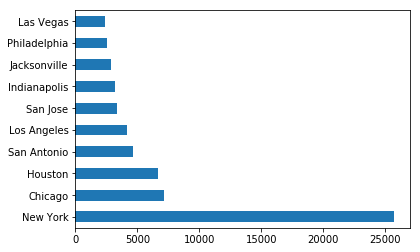

In [26]:
city.plot.barh()

### Clearly define the metric first:

#### Metric: Revenue 

#### Guardrail Metric: User conversion rate

In [29]:
# Check if this test has the minimal required sample size

sig = 0.05
power= 0.8
baseline_rate = sum(df['converted']) / len(df['converted'])
practical_significance = 0.01 
effect_size = sm.stats.proportion_effectsize(baseline_rate, baseline_rate + practical_significance)
sample_size = sm.stats.NormalIndPower().solve_power(effect_size = effect_size, power = power, 
                                               alpha = sig, ratio=1)
print("Required sample size: ", round(sample_size), " per group")


Required sample size:  3536  per group


In [30]:
print('test group has {} users'.format(len(df[df['test'] ==1])))

test group has 114073 users


In [31]:
print('control group has {} users'.format(len(df[df['test'] ==0])))

control group has 202727 users


In [35]:
# Run A/B Test
#To do this we calculate a pooled probability and pooled standard error, a margin of error and the upper and lower bounds of the confidence interval.


#Calculate pooled probability
control = (df["test"] == 0)
conversions_control = df["converted"][control].sum()
total_users_control = df["converted"][control].count()

test = (df["test"] == 1)
conversions_treatment = df["converted"][test].sum()
total_users_treatment = df["converted"][test].count()

prob_pooled = (conversions_control + conversions_treatment) / (total_users_control + total_users_treatment)

print(prob_pooled)

0.018333333333333333


In [43]:
#Calculate pooled standard error and margin of error
se_pooled = math.sqrt(prob_pooled * (1 - prob_pooled) * (1 / total_users_control + 1 / total_users_treatment))
z_score = st.norm.ppf(1 - sig / 2)
margin_of_error = se_pooled * z_score

#Calculate dhat, the estimated difference between probability of conversions in the experiment and control groups
d_hat = (conversions_treatment / total_users_treatment) - (conversions_control / total_users_control)

#Test if we can reject the null hypothesis
lower_bound = d_hat - margin_of_error
upper_bound = d_hat + margin_of_error

In [44]:
if practical_significance < lower_bound:
    print("Reject null hypothesis")
else: 
    print("Do not reject the null hypothesis")
    
print("The lower bound of the confidence interval is ", round(lower_bound * 100, 2), "%")
print("The upper bound of the confidence interval is ", round(upper_bound * 100, 2), "%")


Do not reject the null hypothesis
The lower bound of the confidence interval is  -0.53 %
The upper bound of the confidence interval is  -0.34 %


In [51]:
## Now check the revenue metric
df['revenue'] = df['converted'] * df['price']
revenue_group = df.groupby('test')['revenue'].sum().reset_index()

In [56]:
control_revenue = revenue_group[revenue_group['test'] == 0].revenue[0]
test_revenue = revenue_group[revenue_group['test'] ==1].revenue[1]

In [72]:
#Calculate the T-test for the means of two independent samples of scores.
#scipy.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate')
t_test = st.ttest_ind(df[df['test'] ==0]['revenue'].values, df[df['test'] ==1]['revenue'].values, equal_var= False)
t_test.pvalue/2

7.703749302339191e-09

## Question 2: The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

In [78]:
convert_group = df.groupby('test')['converted'].mean().reset_index()

In [80]:
print(convert_group)

   test  converted
0     0   0.019904
1     1   0.015543


In [81]:
# The conversion rate might dropped after price increases

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316800 entries, 0 to 316799
Data columns (total 13 columns):
user_id             316800 non-null int64
timestamp           316800 non-null object
source              316800 non-null object
device              316800 non-null object
operative_system    316800 non-null object
test                316800 non-null int64
price               316800 non-null int64
converted           316800 non-null int64
city                275616 non-null object
country             275616 non-null object
lat                 275616 non-null float64
long                275616 non-null float64
revenue             316800 non-null int64
dtypes: float64(2), int64(5), object(6)
memory usage: 43.8+ MB


In [88]:
os= df.groupby(['operative_system', 'test'])['converted'].mean().reset_index()

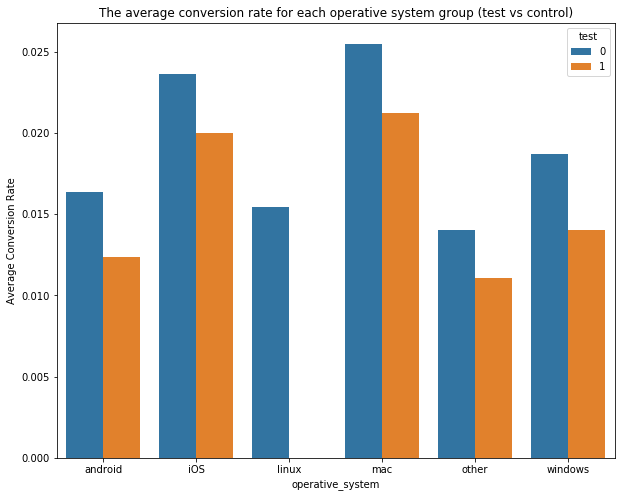

In [96]:
fig, ax = plt.subplots(figsize= (10,8))
sns.barplot(x = 'operative_system', y= 'converted', hue = 'test', data= os)
plt.title('The average conversion rate for each operative system group (test vs control)')
plt.ylabel('Average Conversion Rate')
plt.show()

1. Conversion rate dropped in the test group for every group
2. Average conversion rate is highest for Mac users no matter in test group or control group. iOS users are the close second;
3. Linux users have the lowest conversion rate after adjusting the price from 39 to 59. Why this happens? are they price senstive users? or this product has tight competition in Linux?

In [97]:
device= df.groupby(['device', 'test'])['converted'].mean().reset_index()

In [98]:
device

,device,test,converted
0,mobile,0,0.019879
1,mobile,1,0.016139
2,web,0,0.019940
3,web,1,0.014725


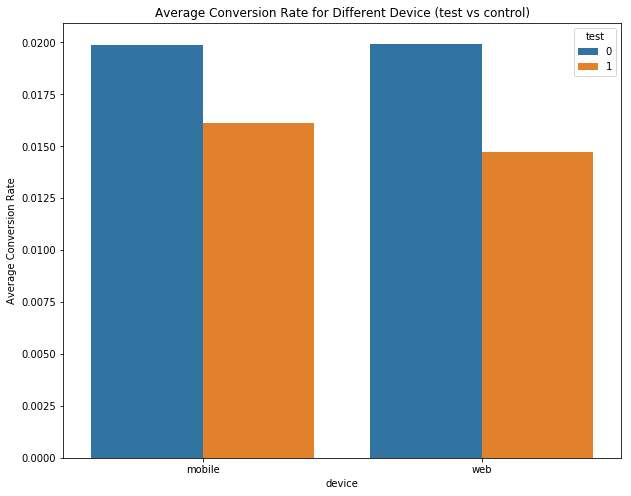

In [99]:
fig, ax = plt.subplots(figsize = (10,8))
sns.barplot(x = 'device', y = 'converted', hue = 'test', data= device)
plt.title('Average Conversion Rate for Different Device (test vs control)')
plt.ylabel('Average Conversion Rate')
plt.show()

1. The conversion rate dropped for each device users group after adjusting price from 39 to 59
2. The conversion rate is almost the same between the mobile and web user group. But after adjusting the price, the web user conversion rate dropped a lot than the mobile user group


In [101]:
source= df.groupby(['source', 'test'])['converted'].mean().reset_index()

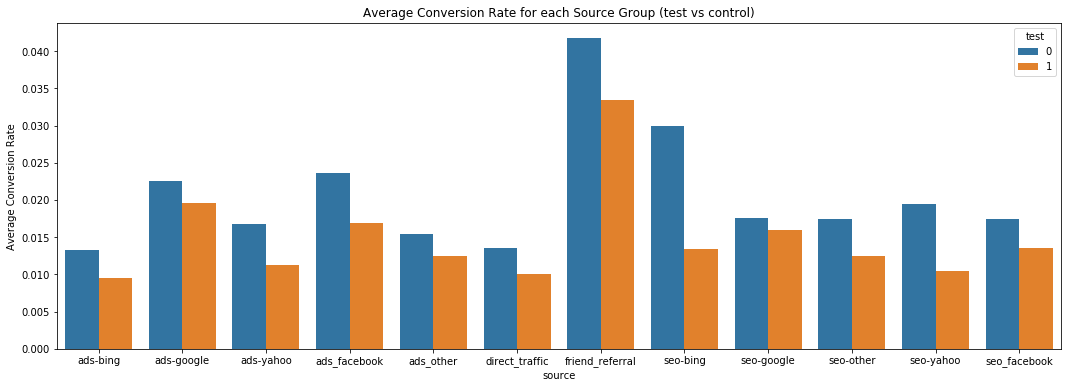

In [105]:
fig, ax = plt.subplots(figsize = (18,6))
sns.barplot(x = 'source', y = 'converted', hue = 'test', data= source)
plt.title('Average Conversion Rate for each Source Group (test vs control)')
plt.ylabel('Average Conversion Rate')
plt.show()

1. Friends referrel group has the highest conversion rate no matter the price adjustment
2. SEO-Bing conversion rate dropped most after adjusting the price from 39 to 59. 
3. Google Ads and Google SEO remains less change compared to other sources when increased price

In [127]:
## Run a random forest model
LB =LabelEncoder()
df['source'] = LB.fit_transform(df['source'])
df['device'] = LB.fit_transform(df['device'])
df['city2'] = LB.fit_transform(df['city'].astype(str))
df['operative_system'] = LB.fit_transform(df['operative_system'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316800 entries, 0 to 316799
Data columns (total 14 columns):
user_id             316800 non-null int64
timestamp           316800 non-null object
source              316800 non-null int64
device              316800 non-null int64
operative_system    316800 non-null int64
test                316800 non-null int64
price               316800 non-null int64
converted           316800 non-null int64
city                275616 non-null object
country             275616 non-null object
lat                 275616 non-null float64
long                275616 non-null float64
revenue             316800 non-null int64
city2               316800 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 46.3+ MB


In [133]:
X= df[['source', 'device', 'operative_system', 'city2', 'test']]
y= df['converted']

In [137]:
RF= RandomForestClassifier()
RF.fit(X,y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

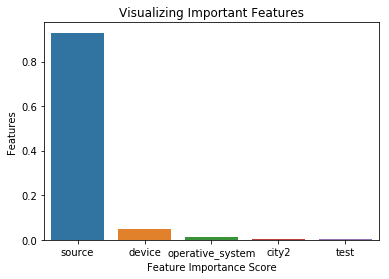

In [138]:
feature_name= X.columns
feature_imp = pd.Series(RF.feature_importances_, index=feature_name).sort_values(ascending=False)
sns.barplot(feature_name, feature_imp)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

#### The most important features that affects conversion is the source feature. Therefore, to make more conversions, VP of product might want to work closely with marketing team and have good marketing plan

## Bonus Question: The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

Note we only need minimal sample size 3536  per group in the experiment. But we don't know the daily traffic data and if data has seasonal variation. So it's hard to see if we can reduce to a shorter time